<a href="https://colab.research.google.com/github/ArushiG11/ML1/blob/main/MiniProject_CS535.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install torch torchvision matplotlib numpy

import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


# Load EMNIST balanced: Load → binarize → visualize. Catch label order, shapes, rotations


#####get data
#####Binarize grayscale to 0/1. Threshold is 0.5. If val>0.5 then it should ebe 1 else 0
#####Group indices by class. Randomly choose 5 per class and Plot with matplotlib.
##### Here I have noticed that the number seemed to be flipped so i added a flip and rotate function function.

In [ ]:
#
def binarize(X_float: np.ndarray, threshold: float = 0.5) -> np.ndarray:
    return (X_float > threshold).astype(np.uint8)

# get data
def load_emnist_balanced(threshold: float = 0.5, root: str = "./data"):
    transform = transforms.Compose([transforms.ToTensor()])  # produces tensors in [0,1]
    ds = datasets.EMNIST(root=root, split="balanced", download=True, transform=transform)

    N = len(ds)
    X = np.stack([ds[i][0].numpy().squeeze(0) for i in range(N)], axis=0)
    y = np.array([int(ds[i][1]) for i in range(N)], dtype=np.int64)

    class_names = getattr(ds, "classes", None)
    if not class_names:
        C = int(y.max()) + 1
        class_names = [str(i) for i in range(C)]
    else:
        class_names = [str(c) for c in class_names]

    X_bin = binarize(X, threshold=threshold)
    return X_bin, y, class_names

# Group indices by class. Randomly choose 5 per class and Plot with matplotlib.
# Here I have noticed that the number seemed to be flipped so i added a flip and rotate function function.

def grid_5_by_C(X_bin, y, class_names, H=28, W=28):
    rng = np.random.default_rng(0)
    C = len(class_names)
    fig, axes = plt.subplots(5, C, figsize=(1.2*C, 6), constrained_layout=True)
    axes = np.atleast_2d(axes)

    for c in range(C):
        idxs = np.where(y == c)[0]
        if len(idxs) < 5:
            raise ValueError(f"Class {c} has <5 samples (found {len(idxs)}).")
        chosen = rng.choice(idxs, size=5, replace=False)

        axes[0, c].set_title(f"{c}: {class_names[c]}", fontsize=8)
        for r, i in enumerate(chosen):
            img = np.fliplr(X_bin[i].reshape(H, W))
            img = np.rot90(img, k=1)
            axes[r, c].imshow(img, cmap="gray")
            axes[r, c].axis("off")
    return fig


Downloading/loading EMNIST (balanced)...


100%|██████████| 562M/562M [00:08<00:00, 66.4MB/s]


Loaded: X_bin=(112800, 28, 28), y=(112800,), classes=47
Rendering 5 x C grid...
Saved to: fig_task1_5xC.png


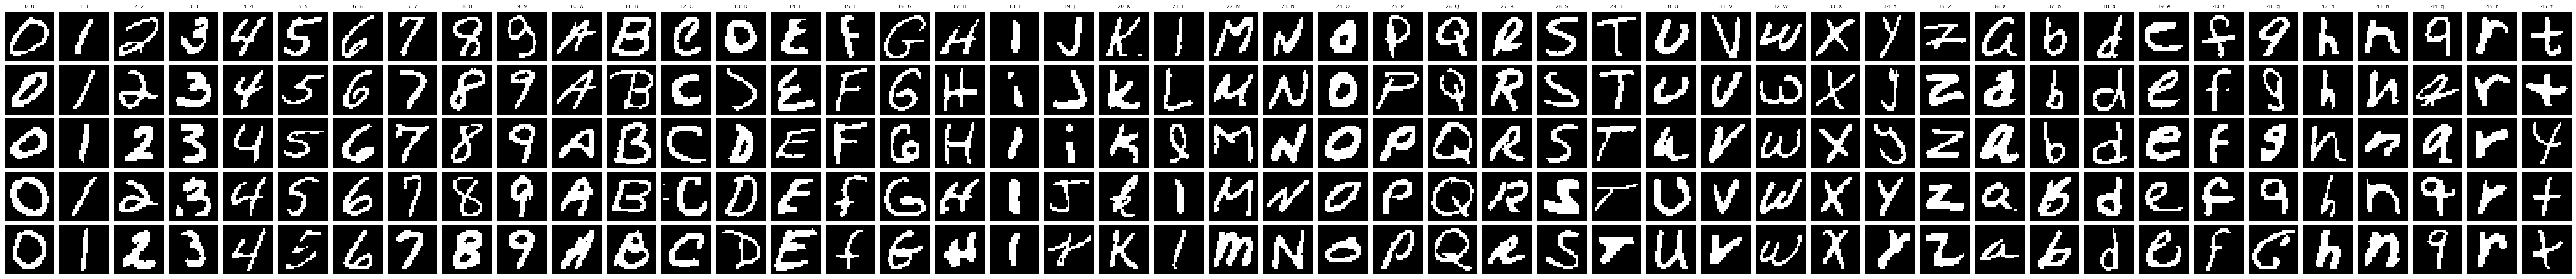

In [ ]:
THRESHOLD = 0.5
DATA_ROOT = "./data"
SAVE_PATH = "fig_task1_5xC.png"


print("Downloading/loading EMNIST (balanced)...")
X_bin, y, class_names = load_emnist_balanced(threshold=THRESHOLD, root=DATA_ROOT)
print(f"Loaded: X_bin={X_bin.shape}, y={y.shape}, classes={len(class_names)}")

print("Rendering 5 x C grid...")
fig = grid_5_by_C(X_bin, y, class_names, H=28, W=28)

if SAVE_PATH:
    fig.savefig(SAVE_PATH, dpi=200, bbox_inches="tight")
    print(f"Saved to: {SAVE_PATH}")

plt.show()


# Estimator that counts, converts to probs (MLE/MAP), **predicts**

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class CategoricalBernoulliNB(BaseEstimator, ClassifierMixin):

    def __init__(self, mode="MAP", alpha=1.0, beta=1.0, threshold=0.5, clip=1e-12):
        self.mode = mode
        self.alpha = float(alpha)
        self.beta  = float(beta)
        self.threshold = float(threshold)
        self.clip = float(clip)

        # learned in fit
        self.classes_ = None
        self.class_count_ = None
        self.feature_count_ = None
        self.class_prior_ = None
        self.feature_prob_ = None

        # precomputed logs for fast prediction
        self.class_log_prior_ = None
        self.log_feature_prob_ = None
        self.log_1m_feature_prob_ = None

    def _check_binary(self, X):
        if not np.array_equal(X, (X > 0).astype(X.dtype)):
            raise ValueError("X must be binary (0/1). Did you binarize with your threshold?")

    def fit(self, X, y):

        X = np.asarray(X)
        y = np.asarray(y)

        if X.ndim != 2:
            raise ValueError("X must be 2D (N, D).")
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of rows.")
        self._check_binary(X)

        N, D = X.shape
        # classes_ will be sorted unique labels (0..C-1 for EMNIST balanced)
        self.classes_, y_idx = np.unique(y, return_inverse=True)
        C = len(self.classes_)

        # n_c: samples per class
        n_c = np.bincount(y_idx, minlength=C).astype(np.float64)  # (C,)

        # m_{c,i}: for each class, count how many times pixel i == 1
        m_ci = np.zeros((C, D), dtype=np.float64)
        for c in range(C):
            rows_c = (y_idx == c)
            if rows_c.sum() == 0:
                raise ValueError(f"Class {self.classes_[c]} has zero samples.")
            m_ci[c] = X[rows_c].sum(axis=0)

        self.class_count_ = n_c
        self.feature_count_ = m_ci

        mode = self.mode.upper()
        if mode == "MLE":
            pi = n_c / float(N)
            theta = m_ci / n_c[:, None]
        elif mode == "MAP":
            pi = (n_c + self.alpha) / (float(N) + C * self.alpha)
            theta = (m_ci + self.beta) / (n_c[:, None] + 2.0 * self.beta)
        else:
            raise ValueError("mode must be 'MLE' or 'MAP'")

        theta = np.clip(theta, self.clip, 1.0 - self.clip)
        pi    = np.clip(pi,    self.clip, 1.0)

        self.class_prior_ = pi
        self.feature_prob_ = theta
        self.class_log_prior_ = np.log(pi)
        self.log_feature_prob_ = np.log(theta)
        self.log_1m_feature_prob_ = np.log(1.0 - theta)
        return self

    def _joint_log_likelihood(self, X):
        X = np.asarray(X)
        self._check_binary(X)
        jll = (X @ self.log_feature_prob_.T) + ((1 - X) @ self.log_1m_feature_prob_.T)
        jll += self.class_log_prior_[None, :]
        return jll

    def predict_log_proba(self, X):
        jll = self._joint_log_likelihood(X)
        # log-softmax
        jll = jll - jll.max(axis=1, keepdims=True)
        logsumexp = np.log(np.exp(jll).sum(axis=1, keepdims=True))
        return jll - logsumexp

    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))

    def predict(self, X):
        jll = self._joint_log_likelihood(X)
        return self.classes_[np.argmax(jll, axis=1)]

    def score(self, X, y):
        X = np.asarray(X); y = np.asarray(y)
        jll = self._joint_log_likelihood(X)
        y_idx = np.searchsorted(self.classes_, y)
        ll_true = jll[np.arange(X.shape[0]), y_idx]
        return float(ll_true.mean())



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Task2.1
N, H, W = X_bin.shape
X_flat = X_bin.reshape(N, H * W)

X_train_bin, X_test_bin, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=0)

# MLE
nb_mle = CategoricalBernoulliNB(mode="MLE", alpha=1.0, beta=1.0, threshold=0.5)
nb_mle.fit(X_train_bin, y_train)
print("MLE class_prior_:\n", nb_mle.class_prior_)
print("MLE feature_prob_:\n", nb_mle.feature_prob_)

# MAP
nb_map = CategoricalBernoulliNB(mode="MAP", alpha=1.0, beta=1.0, threshold=0.5)
nb_map.fit(X_train_bin, y_train)
print("MAP class_prior_:\n", nb_map.class_prior_)
print("MAP feature_prob_:\n", nb_map.feature_prob_)


MLE class_prior_:
 [0.02119902 0.02140957 0.02137633 0.0209109  0.02142066 0.02160904
 0.02119902 0.02117686 0.02113254 0.02132092 0.02158688 0.02128768
 0.02162012 0.02154255 0.02138741 0.02101064 0.02124335 0.02142066
 0.02136525 0.02106605 0.02104388 0.02148715 0.02088874 0.02135417
 0.02155363 0.02123227 0.02109929 0.0212766  0.02132092 0.02135417
 0.0210328  0.0211547  0.02087766 0.02124335 0.02142066 0.02128768
 0.02116578 0.02158688 0.02121011 0.0214539  0.021332   0.02116578
 0.02118794 0.02107713 0.02119902 0.02119902 0.02150931]
MLE feature_prob_:
 [[1.e-12 1.e-12 1.e-12 ... 1.e-12 1.e-12 1.e-12]
 [1.e-12 1.e-12 1.e-12 ... 1.e-12 1.e-12 1.e-12]
 [1.e-12 1.e-12 1.e-12 ... 1.e-12 1.e-12 1.e-12]
 ...
 [1.e-12 1.e-12 1.e-12 ... 1.e-12 1.e-12 1.e-12]
 [1.e-12 1.e-12 1.e-12 ... 1.e-12 1.e-12 1.e-12]
 [1.e-12 1.e-12 1.e-12 ... 1.e-12 1.e-12 1.e-12]]
MAP class_prior_:
 [0.02119907 0.02140951 0.02137628 0.02091109 0.02142058 0.02160887
 0.02119907 0.02117691 0.02113261 0.0213209  0.02

In [ ]:
# Task 2.1
nb = CategoricalBernoulliNB(mode="MAP", alpha=1.0, beta=1.0, threshold=0.5)
nb.fit(X_train_bin, y_train)

print("Class prior (pi) shape:", nb.class_prior_.shape)
print("First 10 class priors:", np.round(nb.class_prior_[:10], 4))

print("Feature prob (theta) shape:", nb.feature_prob_.shape)  # (C, D)
C, D = nb.feature_prob_.shape
for c in range(min(C, 3)):  # show first 3 classes
    print(f"[Class {c}] first 12 thetas:", np.round(nb.feature_prob_[c, :12], 3))

# quick sanity
ink_density = nb.feature_prob_.mean(axis=1)
print("Mean theta per class (ink density):", np.round(ink_density[:10], 3))


Class prior (pi) shape: (47,)
First 10 class priors: [0.0212 0.0214 0.0214 0.0209 0.0214 0.0216 0.0212 0.0212 0.0211 0.0213]
Feature prob (theta) shape: (47, 784)
[Class 0] first 12 thetas: [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
[Class 1] first 12 thetas: [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
[Class 2] first 12 thetas: [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
Mean theta per class (ink density): [0.213 0.094 0.191 0.185 0.157 0.165 0.179 0.144 0.199 0.16 ]


In [ ]:
print("Avg log-likelihood (train) MLE vs MAP:",
      nb_mle.score(X_train_bin, y_train), nb_map.score(X_train_bin, y_train))
print("Avg log-likelihood (test)   MLE vs MAP:",
      nb_mle.score(X_test_bin, y_test),     nb_map.score(X_test_bin, y_test))


Avg log-likelihood (train) MLE vs MAP: -228.44380881562068 -228.56461694964835
Avg log-likelihood (test)   MLE vs MAP: -229.75510038028352 -229.6684015341729


In [ ]:
nb = CategoricalBernoulliNB(mode="MAP", alpha=1.0, beta=1.0, threshold=0.5)
nb.fit(X_train_bin, y_train)

# Task 2.1
print("Class priors:", np.round(nb.class_prior_[:10], 4), " ...")
print("Theta shape:", nb.feature_prob_.shape)

# Task 2.2
probs = nb.predict_proba(X_test_bin[:5])
preds = nb.predict(X_test_bin[:5])
print("First 5 predicted classes:", preds)
print("First row probs (truncated):", np.round(probs[0, :10], 3), "...")

# Task 2.3: average log-likelihood
print("Avg log-likelihood (test):", nb.score(X_test_bin, y_test))

Class priors: [0.0212 0.0214 0.0214 0.0209 0.0214 0.0216 0.0212 0.0212 0.0211 0.0213]  ...
Theta shape: (47, 784)
First 5 predicted classes: [ 5 45 10 11 19]
First row probs (truncated): [0.    0.    0.    0.    0.    0.999 0.    0.    0.    0.   ] ...
Avg log-likelihood (test): -229.6684015341729


In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# assume you already have X_train_bin, y_train, X_test_bin, y_test
# pick 10% of the data as your training pool
pool_size = int(0.1 * len(X_train_bin))
rng = np.random.default_rng(0)
idxs = rng.choice(len(X_train_bin), size=pool_size, replace=False)
X_pool, y_pool = X_train_bin[idxs], y_train[idxs]


In [ ]:
def run_learning_curve(estimator, X, y, train_fracs, X_test, y_test):
    train_scores, test_scores = [], []
    N = len(X)
    for frac in train_fracs:
        n = int(frac * N)
        idx = rng.choice(N, n, replace=False)
        X_sub, y_sub = X[idx], y[idx]
        estimator.fit(X_sub, y_sub)
        train_ll = estimator.score(X_sub, y_sub)
        test_ll = estimator.score(X_test, y_test)
        train_scores.append(train_ll)
        test_scores.append(test_ll)
    return np.array(train_scores), np.array(test_scores)


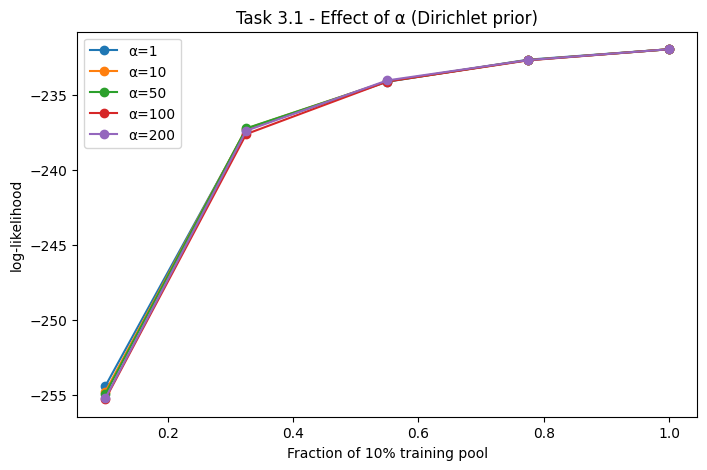

In [ ]:
# Task 3.1
alphas = [1, 10, 50, 100, 200]
train_fracs = np.linspace(0.1, 1.0, 5)

plt.figure(figsize=(8,5))
for a in alphas:
    nb = CategoricalBernoulliNB(mode="MAP", alpha=a, beta=1.0, threshold=0.5)
    train_ll, test_ll = run_learning_curve(nb, X_pool, y_pool, train_fracs, X_test_bin, y_test)
    plt.plot(train_fracs, test_ll, marker="o", label=f"α={a}")
plt.xlabel("Fraction of 10% training pool")
plt.ylabel("log-likelihood")
plt.title("Task 3.1 - Effect of α (Dirichlet prior)")
plt.legend()
plt.show()

All curves (α = 1 → 200) lie almost on top of each other. For small data, log-likelihood is slightly lower (≈ −255) and rises as we add more data (≈ −235).Changing α barely shifts the lines.

α controls how uniform the class prior is assumed to be.
Because the EMNIST Balanced dataset is already perfectly balanced, the empirical counts ≈ 1/47 anyway.
So:
Larger α only smooths π₍c₎ a bit toward uniform, but since it’s already uniform, nothing changes.
Learning-curve shape (steep improvement early, flat later) shows the model stabilizes quickly once a few thousand examples per class are seen.

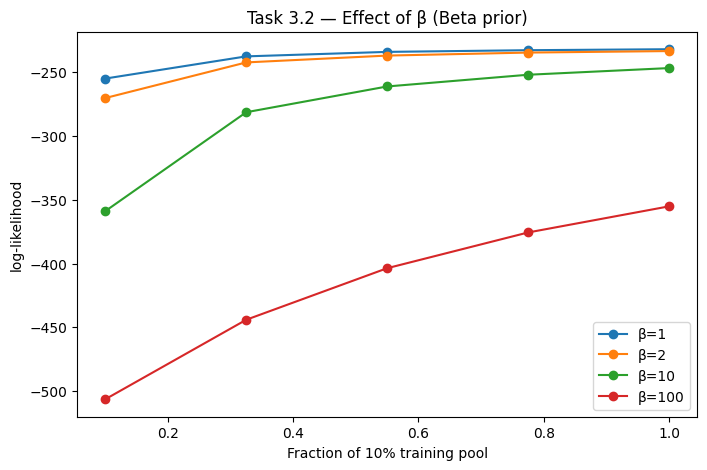

In [ ]:
# Task 3.2
betas = [1, 2, 10, 100]
train_fracs = np.linspace(0.1, 1.0, 5)

plt.figure(figsize=(8,5))
for b in betas:
    nb = CategoricalBernoulliNB(mode="MAP", alpha=1.0, beta=b, threshold=0.5)
    train_ll, test_ll = run_learning_curve(nb, X_pool, y_pool, train_fracs, X_test_bin, y_test)
    plt.plot(train_fracs, test_ll, marker="o", label=f"β={b}")
plt.xlabel("Fraction of 10% training pool")
plt.ylabel("log-likelihood")
plt.title("Task 3.2 — Effect of β (Beta prior)")
plt.legend()
plt.show()

β = 1 and β = 2 perform best (highest / least-negative log-likelihood).

β = 10 is noticeably worse for small data but still improves as size grows.

β = 100 performs poorly everywhere—very low likelihoods, even with full data.

💡 Meaning

β controls how strongly we smooth pixel-on probabilities θ₍c,i₎ toward 0.5.

Small β (1–2) → light smoothing, lets data dominate → better fit when plenty of samples exist.

Medium β (10) → more shrinkage toward 0.5, good when classes have few samples, but hurts when enough data are available.

Large β (100) → extreme smoothing, forcing every pixel probability close to 0.5 → model can’t distinguish digits → underfits → very low likelihoods.

So the curve shows the classic bias–variance trade-off:

Increasing β reduces variance but adds bias; small β wins when data are sufficient.

# Task 4 - Generates an imbalanced subset based on a Dirichlet(α_class) draw.

In [ ]:
# Task 4 - Generates an imbalanced subset based on a Dirichlet(α_class) draw.
def stratified_dirichlet_subset(X, y, total_n, alpha_class, seed=None):

    # Build an imbalanced subset of size total_n using a Dirichlet draw over classes. Returns X_sub, y_sub.

    r = np.random.default_rng(seed)
    classes = np.unique(y)
    C = len(classes)

    # sample class mix p ~ Dirichlet(alpha_class * 1_C)
    p = r.dirichlet([alpha_class] * C)
    # intended counts per class
    counts = np.floor(p * total_n).astype(int)

    chosen = []
    for c, k in zip(classes, counts):
        idx = np.where(y == c)[0]
        if k > 0:
            k = min(k, len(idx))
            pick = r.choice(idx, size=k, replace=False)
            chosen.append(pick)

    if not chosen:
        return X[:0], y[:0]

    chosen = np.concatenate(chosen)
    r.shuffle(chosen)
    return X[chosen], y[chosen]


In [ ]:
def safe_score_on_seen_classes(estimator, X, y):
    # Only keep samples whose labels are in estimator.classes
    mask = np.isin(y, estimator.classes_)
    if not np.any(mask):
        return np.nan   # or raise
    X_seen, y_seen = X[mask], y[mask]
    return estimator.score(X_seen, y_seen)

In [ ]:
def run_learning_curve_on_subset(estimator, X_full, y_full, train_fracs, X_test, y_test, seed=0):
    r = np.random.default_rng(seed)
    N = len(X_full)
    train_scores, test_scores = [], []
    for frac in train_fracs:
        n = max(1, int(frac * N))
        idx = r.choice(N, size=n, replace=False)
        X_sub, y_sub = X_full[idx], y_full[idx]
        estimator.fit(X_sub, y_sub)
        train_scores.append(estimator.score(X_sub, y_sub))
        test_scores.append(safe_score_on_seen_classes(estimator, X_test, y_test))
    return np.array(train_scores), np.array(test_scores)


# **Task 4.1 — Understanding the Effect of Beta (β)**

Under class imbalance, MAP clearly performs better than MLE. The dashed MLE curve stays much lower across all training sizes, that’s the classic MLE failure pattern: it overfits to the majority classes, assigns almost zero probability to minority classes, and therefore performs poorly on the validation set (which is more balanced).

**Within MAP:**

Small beta values (around 1–2) work best. This gives light smoothing — it prevents zero probabilities while still allowing the data to drive the learning.

As beta increases (10 → 100), the model becomes over-smoothed. Pixel probabilities start drifting toward 0.5, reducing contrast between classes and leading to underfitting.

As we add more (still imbalanced) training data, MAP’s validation log-likelihood improves and then plateaus.
For MLE, the validation log-likelihood can even get worse because adding more of the same skew reinforces the majority-class bias.

Why MLE is Unaffected by Beta

Beta (β) is the hyperparameter of the Beta prior, and it is used only in MAP estimation, not in MLE.

In MLE (Maximum Likelihood Estimation), there are no priors.
The pixel probabilities are computed directly from frequency counts:

theta(c, i) = m(c, i) / n(c)

where:

m(c, i) = number of “ink” pixels (value 1) for class c and pixel i

n(c) = total number of training samples for that class

So MLE is purely data-driven — no beta, no alpha.

In MAP (Maximum A Posteriori) estimation, we apply Beta(β, β) smoothing:

theta(c, i) = (m(c, i) + β - 1) / (n(c) + 2 * (β - 1))

This adds pseudo-counts and prevents zero probabilities for unseen pixels.

Therefore, when beta changes, MLE stays constant because beta never enters its equation.
Only MAP changes with beta — that’s exactly what your graphs show.

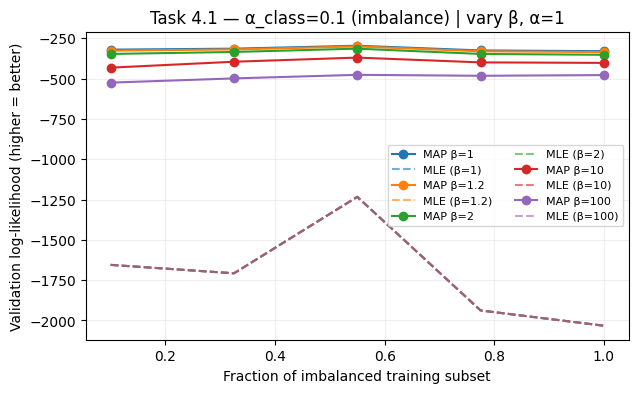

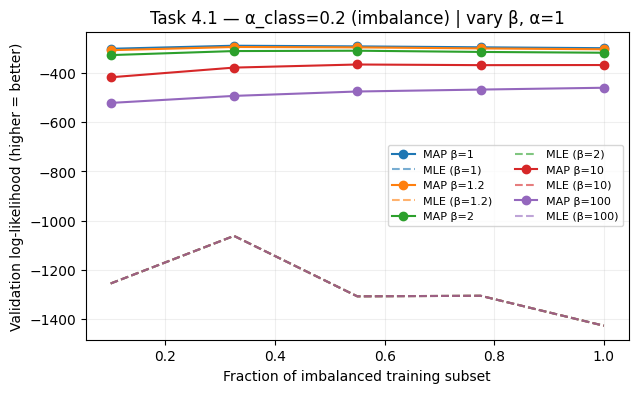

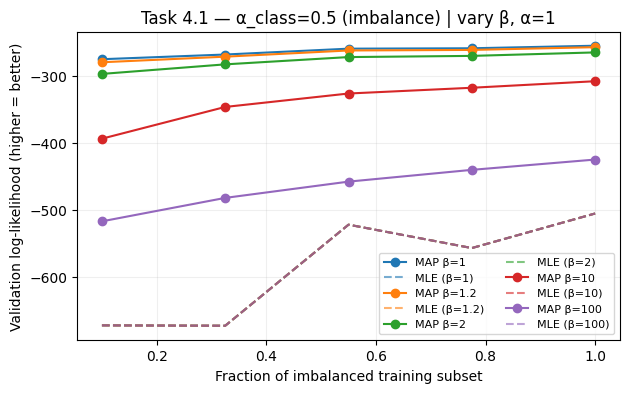

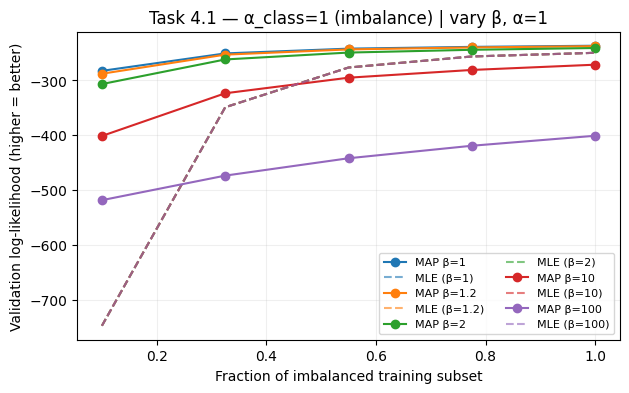

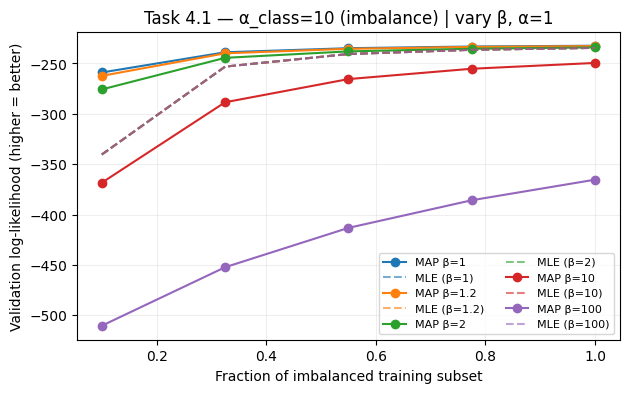

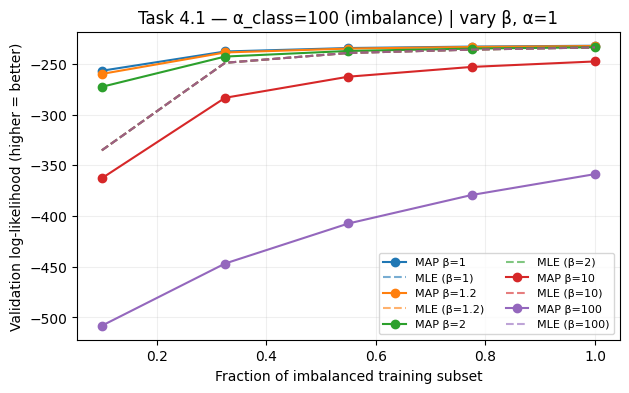

In [ ]:
# Task 4.1
alpha_class_values = [0.1, 0.2, 0.5, 1, 10, 100]
betas = [1, 1.2, 2, 10, 100]
train_fracs = np.linspace(0.1, 1.0, 5)

for aclass in alpha_class_values:
    # Build one imbalanced pool of the SAME SIZE as X_pool using Dirichlet(alpha_class)
    X_imb, y_imb = stratified_dirichlet_subset(X_pool, y_pool, total_n=len(X_pool), alpha_class=aclass, seed=42)

    plt.figure(figsize=(7,4))
    for beta in betas:
        # Compare MLE vs MAP (β only used by MAP)
        nb_mle = CategoricalBernoulliNB(mode="MLE", threshold=0.5)
        nb_map = CategoricalBernoulliNB(mode="MAP", alpha=1.0, beta=beta, threshold=0.5)

        # Learning curve on the *imbalanced* subset
        _, test_ll_mle = run_learning_curve_on_subset(nb_mle, X_imb, y_imb, train_fracs, X_test_bin, y_test, seed=0)
        _, test_ll_map = run_learning_curve_on_subset(nb_map, X_imb, y_imb, train_fracs, X_test_bin, y_test, seed=0)

        # Show MAP (solid) vs MLE (dashed) for the same β
        plt.plot(train_fracs, test_ll_map, marker='o', label=f"MAP β={beta}")
        plt.plot(train_fracs, test_ll_mle, ls='--', color=plt.gca().lines[-1].get_color(), alpha=0.6, label=f"MLE (β={beta})")

    plt.title(f"Task 4.1 — α_class={aclass} (imbalance) | vary β, α=1")
    plt.xlabel("imbalanced training subset")
    plt.ylabel("log-likelihood")
    plt.legend(ncol=2, fontsize=8)
    plt.grid(alpha=0.2)
    plt.show()


# **Task 4.2 — vary α (class-prior smoothing) with imbalanced training (α_class = 0.1), β = 1**

Again, MAP >> MLE across the board. MLE’s dashed curve is way down, which is exactly what you expect when a bunch of classes are under-represented or even missing in the training subset.

Interestingly, changing α barely moves the MAP curve here. the model already benefits a ton from pixel-level smoothing (β=1) and from just not being MLE. nudging the class prior toward uniform (bigger α) doesn’t change much because the catastrophic issue—rare-class likelihoods—is already handled by the Bernoulli β smoothing and the fact that MAP won’t let priors go to zero.

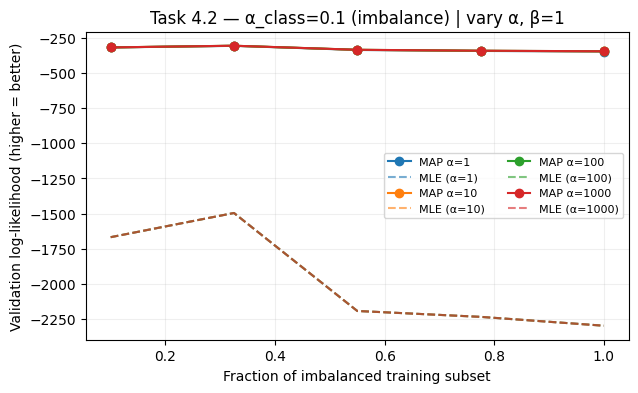

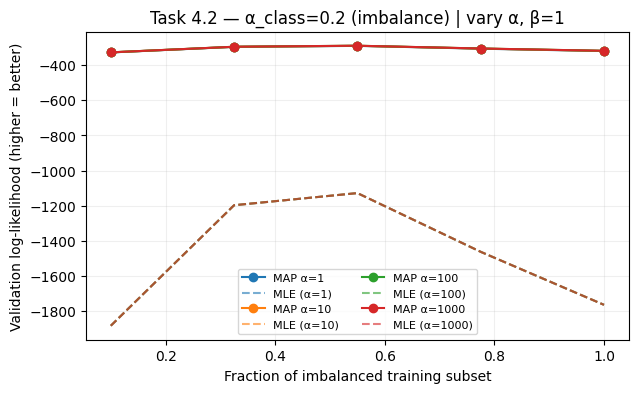

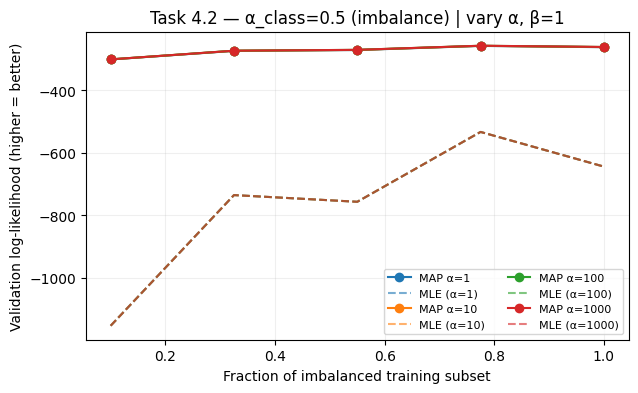

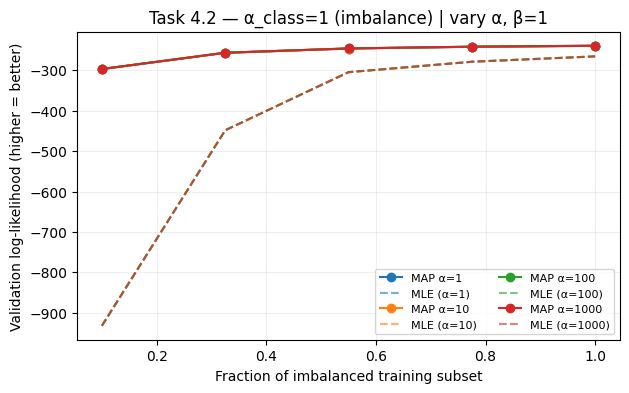

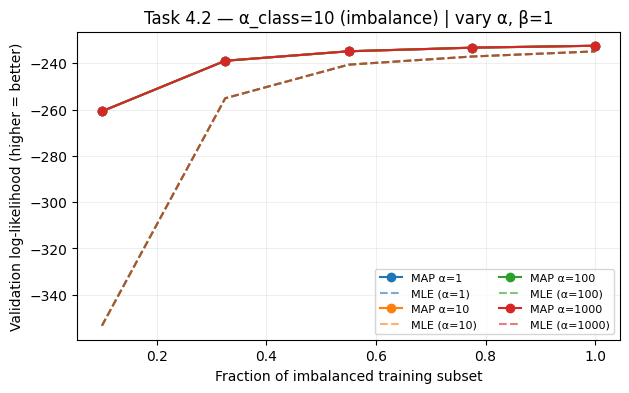

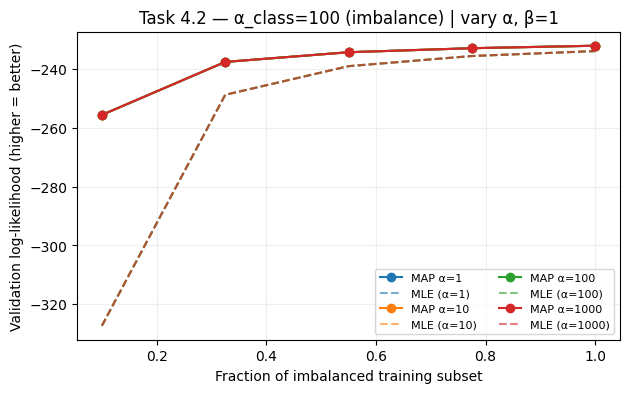

In [ ]:
alpha_class_values = [0.1, 0.2, 0.5, 1, 10, 100]
alphas = [1, 10, 100, 1000]
train_fracs = np.linspace(0.1, 1.0, 5)

for aclass in alpha_class_values:
    X_imb, y_imb = stratified_dirichlet_subset(X_pool, y_pool, total_n=len(X_pool), alpha_class=aclass, seed=123)

    plt.figure(figsize=(7,4))
    for alpha in alphas:
        # Compare MLE vs MAP (α only used by MAP)
        nb_mle = CategoricalBernoulliNB(mode="MLE", threshold=0.5)
        nb_map = CategoricalBernoulliNB(mode="MAP", alpha=alpha, beta=1.0, threshold=0.5)

        _, test_ll_mle = run_learning_curve_on_subset(nb_mle, X_imb, y_imb, train_fracs, X_test_bin, y_test, seed=1)
        _, test_ll_map = run_learning_curve_on_subset(nb_map, X_imb, y_imb, train_fracs, X_test_bin, y_test, seed=1)

        plt.plot(train_fracs, test_ll_map, marker='o', label=f"MAP α={alpha}")
        plt.plot(train_fracs, test_ll_mle, ls='--', color=plt.gca().lines[-1].get_color(), alpha=0.6, label=f"MLE (α={alpha})")

    plt.title(f"Task 4.2 — α_class={aclass} (imbalance) | vary α, β=1")
    plt.xlabel("Imbalanced training subset")
    plt.ylabel("log-likelihood")
    plt.legend(ncol=2, fontsize=8)
    plt.grid(alpha=0.2)
    plt.show()


# **Task 5.1 How does the generalization performance of each model change as a function of the amount of training data and the choice of hyper-parameters?**

1. As training data increases: Validation performance rises quickly at small sizes, then flattens . MLE looks better on the training set, but doesn’t generalize as well. MAP is usually better on validation, especially when data are limited or skewed.Therefore, both MLE and MAP improve as size grows; MAP should win earlier (smoother, less overfit), especially under imbalance or small-N per class.

2. Effect of α (class prior): On the balanced EMNIST split, changing α has little effect (empirical class frequencies are already ~uniform). Under imbalance, larger α (more uniform prior) stabilizes class priors and helps MAP avoid collapsing rare classes.

3. Effect of β (pixel prior): Small β (≈1–2): best validation performance. Light smoothing prevents zero/one probs without washing out signal. Medium/Large β (≥10): increasing shrinkage toward 0.5 → underfitting; validation log-likelihood drops.
MLE is unaffected by β (no priors), which is a good sanity check.

4. Effect of class imbalance (Dirichlet α_class for sampling): MLE degrades sharply: chases majority classes, assigns near-zero probability to rare classes, hurts validation. MAP is robust: priors act like guardrails; MAP >> MLE across training sizes when data are imbalanced.

# Task 5.2: Which model would you select for deployment and why?

<!-- MAP Bernoulli Naive Bayes with β ≈ 1–2 and a modest α.
On balanced data: α ≈ 1 is fine (little impact).
If production may be skewed: α in [10, 50] (or tune via CV) to keep class priors stable. -->
I'd deploy MAP NB with small pixel smoothing (β≈1–2) and a modest class-prior α because it consistently generalizes better than MLE, stays stable under class skew, and avoids zero-probability pathologies while remaining simple and fast.
